In [105]:
import pandas as pd
import string
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, ParameterSampler
import matplotlib.pyplot as plt


from nltk.tokenize.casual import TweetTokenizer

In [34]:
conda install -c conda-forge xgboost 

Password:


In [4]:
# YOU ONLY NEED TO RUN  THIS ONCE(IF YOU HAVEN'T)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/hcao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# read the raw data and show the data
raw_data = pd.read_csv("./Data/Raw/ExtractedTweets.csv")
raw_data.head()

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


In [6]:
raw_data.Party.unique()

array(['Democrat', 'Republican'], dtype=object)

In [7]:
raw_data.info

<bound method DataFrame.info of             Party         Handle  \
0        Democrat  RepDarrenSoto   
1        Democrat  RepDarrenSoto   
2        Democrat  RepDarrenSoto   
3        Democrat  RepDarrenSoto   
4        Democrat  RepDarrenSoto   
...           ...            ...   
86455  Republican    RepTomPrice   
86456  Republican    RepTomPrice   
86457  Republican    RepTomPrice   
86458  Republican    RepTomPrice   
86459  Republican    RepTomPrice   

                                                   Tweet  
0      Today, Senate Dems vote to #SaveTheInternet. P...  
1      RT @WinterHavenSun: Winter Haven resident / Al...  
2      RT @NBCLatino: .@RepDarrenSoto noted that Hurr...  
3      RT @NALCABPolicy: Meeting with @RepDarrenSoto ...  
4      RT @Vegalteno: Hurricane season starts on June...  
...                                                  ...  
86455  Check out my op-ed on need for End Executive O...  
86456  Yesterday, Betty &amp; I had a great time lear...  
8645

# Data cleaning
Before we start to vectorizing the tweets, we firstly need to clean the tweets text

- Remove punctuations
- Remove special symbols, e.g. @xxx
- Remove stop words
- stemmming

TODO: nltk has a class called TweetTokenizer, poentially can be used.

In [8]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [9]:
def remove_punctuations(t):
    t = re.sub('@\w+','', t)
    t = "".join([char for char in t if char not in string.punctuation])
    t = re.sub('[0-9]+', '', t)
    return t

In [10]:
raw_data['tweet_no_punc'] = raw_data.Tweet.apply(lambda x: remove_punctuations(x))

In [11]:
raw_data.head(10)

,Party,Handle,Tweet,tweet_no_punc
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",Today Senate Dems vote to SaveTheInternet Prou...
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,RT Winter Haven resident Alta Vista teacher ...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,RT noted that Hurricane Maria has left appro...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,RT Meeting with Thanks for taking the time ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,RT Hurricane season starts on June st Puerto ...
5,Democrat,RepDarrenSoto,RT @EmgageActionFL: Thank you to all who came ...,RT Thank you to all who came out to our Orlan...
6,Democrat,RepDarrenSoto,Hurricane Maria left approx $90 billion in dam...,Hurricane Maria left approx billion in damage...
7,Democrat,RepDarrenSoto,RT @Tharryry: I am delighted that @RepDarrenSo...,RT I am delighted that will be voting for th...
8,Democrat,RepDarrenSoto,RT @HispanicCaucus: Trump's anti-immigrant pol...,RT Trumps antiimmigrant policies are hurting ...
9,Democrat,RepDarrenSoto,RT @RepStephMurphy: Great joining @WeAreUnidos...,RT Great joining and for a roundtable in Or...


In [12]:
def tokenization(t):
    t = re.split('\W+', t)
    return t

In [13]:
raw_data['tokenized'] = raw_data.tweet_no_punc.apply(lambda x: tokenization(x))

In [14]:
raw_data.head(10)

,Party,Handle,Tweet,tweet_no_punc,tokenized
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",Today Senate Dems vote to SaveTheInternet Prou...,"[Today, Senate, Dems, vote, to, SaveTheInterne..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,RT Winter Haven resident Alta Vista teacher ...,"[RT, Winter, Haven, resident, Alta, Vista, tea..."
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,RT noted that Hurricane Maria has left appro...,"[RT, noted, that, Hurricane, Maria, has, left,..."
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,RT Meeting with Thanks for taking the time ...,"[RT, Meeting, with, Thanks, for, taking, the, ..."
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,RT Hurricane season starts on June st Puerto ...,"[RT, Hurricane, season, starts, on, June, st, ..."
5,Democrat,RepDarrenSoto,RT @EmgageActionFL: Thank you to all who came ...,RT Thank you to all who came out to our Orlan...,"[RT, Thank, you, to, all, who, came, out, to, ..."
6,Democrat,RepDarrenSoto,Hurricane Maria left approx $90 billion in dam...,Hurricane Maria left approx billion in damage...,"[Hurricane, Maria, left, approx, billion, in, ..."
7,Democrat,RepDarrenSoto,RT @Tharryry: I am delighted that @RepDarrenSo...,RT I am delighted that will be voting for th...,"[RT, I, am, delighted, that, will, be, voting,..."
8,Democrat,RepDarrenSoto,RT @HispanicCaucus: Trump's anti-immigrant pol...,RT Trumps antiimmigrant policies are hurting ...,"[RT, Trumps, antiimmigrant, policies, are, hur..."
9,Democrat,RepDarrenSoto,RT @RepStephMurphy: Great joining @WeAreUnidos...,RT Great joining and for a roundtable in Or...,"[RT, Great, joining, and, for, a, roundtable, ..."


In [15]:
def remove_stop_words(t):
    t = [word for word in t if word not in stopword]
    return t

In [16]:
stopword = nltk.corpus.stopwords.words('english')

In [17]:
raw_data['no_stop_words'] = raw_data.tokenized.apply(lambda x: remove_stop_words(x))

In [18]:
raw_data.head(10)

,Party,Handle,Tweet,tweet_no_punc,tokenized,no_stop_words
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",Today Senate Dems vote to SaveTheInternet Prou...,"[Today, Senate, Dems, vote, to, SaveTheInterne...","[Today, Senate, Dems, vote, SaveTheInternet, P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,RT Winter Haven resident Alta Vista teacher ...,"[RT, Winter, Haven, resident, Alta, Vista, tea...","[RT, Winter, Haven, resident, Alta, Vista, tea..."
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,RT noted that Hurricane Maria has left appro...,"[RT, noted, that, Hurricane, Maria, has, left,...","[RT, noted, Hurricane, Maria, left, approximat..."
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,RT Meeting with Thanks for taking the time ...,"[RT, Meeting, with, Thanks, for, taking, the, ...","[RT, Meeting, Thanks, taking, time, meet, ED, ..."
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,RT Hurricane season starts on June st Puerto ...,"[RT, Hurricane, season, starts, on, June, st, ...","[RT, Hurricane, season, starts, June, st, Puer..."
5,Democrat,RepDarrenSoto,RT @EmgageActionFL: Thank you to all who came ...,RT Thank you to all who came out to our Orlan...,"[RT, Thank, you, to, all, who, came, out, to, ...","[RT, Thank, came, Orlando, gala, It, successfu..."
6,Democrat,RepDarrenSoto,Hurricane Maria left approx $90 billion in dam...,Hurricane Maria left approx billion in damage...,"[Hurricane, Maria, left, approx, billion, in, ...","[Hurricane, Maria, left, approx, billion, dama..."
7,Democrat,RepDarrenSoto,RT @Tharryry: I am delighted that @RepDarrenSo...,RT I am delighted that will be voting for th...,"[RT, I, am, delighted, that, will, be, voting,...","[RT, I, delighted, voting, CRA, overrule, FCC,..."
8,Democrat,RepDarrenSoto,RT @HispanicCaucus: Trump's anti-immigrant pol...,RT Trumps antiimmigrant policies are hurting ...,"[RT, Trumps, antiimmigrant, policies, are, hur...","[RT, Trumps, antiimmigrant, policies, hurting,..."
9,Democrat,RepDarrenSoto,RT @RepStephMurphy: Great joining @WeAreUnidos...,RT Great joining and for a roundtable in Or...,"[RT, Great, joining, and, for, a, roundtable, ...","[RT, Great, joining, roundtable, Orlando, fede..."


In [19]:
ps = nltk.PorterStemmer()

In [20]:
def stemming(t):
    t = [ps.stem(word) for word in t]
    return t

In [21]:
raw_data['stemmed'] = raw_data.no_stop_words.apply(lambda x: stemming(x))

In [22]:
raw_data.head(10)

,Party,Handle,Tweet,tweet_no_punc,tokenized,no_stop_words,stemmed
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",Today Senate Dems vote to SaveTheInternet Prou...,"[Today, Senate, Dems, vote, to, SaveTheInterne...","[Today, Senate, Dems, vote, SaveTheInternet, P...","[today, senat, dem, vote, savetheinternet, pro..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,RT Winter Haven resident Alta Vista teacher ...,"[RT, Winter, Haven, resident, Alta, Vista, tea...","[RT, Winter, Haven, resident, Alta, Vista, tea...","[RT, winter, haven, resid, alta, vista, teache..."
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,RT noted that Hurricane Maria has left appro...,"[RT, noted, that, Hurricane, Maria, has, left,...","[RT, noted, Hurricane, Maria, left, approximat...","[RT, note, hurrican, maria, left, approxim, bi..."
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,RT Meeting with Thanks for taking the time ...,"[RT, Meeting, with, Thanks, for, taking, the, ...","[RT, Meeting, Thanks, taking, time, meet, ED, ...","[RT, meet, thank, take, time, meet, ED, marucc..."
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,RT Hurricane season starts on June st Puerto ...,"[RT, Hurricane, season, starts, on, June, st, ...","[RT, Hurricane, season, starts, June, st, Puer...","[RT, hurrican, season, start, june, st, puerto..."
5,Democrat,RepDarrenSoto,RT @EmgageActionFL: Thank you to all who came ...,RT Thank you to all who came out to our Orlan...,"[RT, Thank, you, to, all, who, came, out, to, ...","[RT, Thank, came, Orlando, gala, It, successfu...","[RT, thank, came, orlando, gala, It, success, ..."
6,Democrat,RepDarrenSoto,Hurricane Maria left approx $90 billion in dam...,Hurricane Maria left approx billion in damage...,"[Hurricane, Maria, left, approx, billion, in, ...","[Hurricane, Maria, left, approx, billion, dama...","[hurrican, maria, left, approx, billion, damag..."
7,Democrat,RepDarrenSoto,RT @Tharryry: I am delighted that @RepDarrenSo...,RT I am delighted that will be voting for th...,"[RT, I, am, delighted, that, will, be, voting,...","[RT, I, delighted, voting, CRA, overrule, FCC,...","[RT, I, delight, vote, cra, overrul, fcc, save..."
8,Democrat,RepDarrenSoto,RT @HispanicCaucus: Trump's anti-immigrant pol...,RT Trumps antiimmigrant policies are hurting ...,"[RT, Trumps, antiimmigrant, policies, are, hur...","[RT, Trumps, antiimmigrant, policies, hurting,...","[RT, trump, antiimmigr, polici, hurt, small, b..."
9,Democrat,RepDarrenSoto,RT @RepStephMurphy: Great joining @WeAreUnidos...,RT Great joining and for a roundtable in Or...,"[RT, Great, joining, and, for, a, roundtable, ...","[RT, Great, joining, roundtable, Orlando, fede...","[RT, great, join, roundtabl, orlando, feder, i..."


In [23]:
wn = nltk.WordNetLemmatizer()

In [24]:
# no need if already stemed, but we can see which one works better tho
def lemmatizer(t):
    t = [wn.lemmatize(w) for w in t]
    return t

In [25]:
# first we clean our existing raw data table
df = raw_data.copy()

In [26]:
df.drop(['tweet_no_punc', 'tokenized', 'no_stop_words'], axis=1)

,Party,Handle,Tweet,stemmed
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...","[today, senat, dem, vote, savetheinternet, pro..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,"[RT, winter, haven, resid, alta, vista, teache..."
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,"[RT, note, hurrican, maria, left, approxim, bi..."
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,"[RT, meet, thank, take, time, meet, ED, marucc..."
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,"[RT, hurrican, season, start, june, st, puerto..."
...,...,...,...,...
86455,Republican,RepTomPrice,Check out my op-ed on need for End Executive O...,"[check, ope, need, end, execut, overreach, act..."
86456,Republican,RepTomPrice,"Yesterday, Betty &amp; I had a great time lear...","[yesterday, betti, amp, I, great, time, learn,..."
86457,Republican,RepTomPrice,We are forever grateful for the service and sa...,"[We, forev, grate, servic, sacrific, major, ba..."
86458,Republican,RepTomPrice,Happy first day of school @CobbSchools! #CobbB...,"[happi, first, day, school, cobbbacktoschool]"


# Task 1: Twitter's political affilication
This task focus on individual tweet's political affilication

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df.Tweet,df.Party, stratify=df.Party, test_size = 0.2, random_state=123)

In [1]:
tokenizer = TweetTokenizer(reduce_len=True)

NameError: name 'TweetTokenizer' is not defined

In [37]:
X_train.head(10)

14800    The Senate Judiciary, in its limited #TrumpRus...
803      If you’re reading this, remember to #ThankATea...
42239    RT @WRHI: U.S. Representative Ralph Norman joi...
24371    RT @HRC: @USRepKeating Congrats on 100% on @HR...
71348    Congrats to @RepLoudermilk on House passage of...
56256    RT @FoxNews: .@RepDougCollins on the Russia in...
78781    RT @hughhewitt: The #SchumerShutdown isn’t pla...
35298    Bipartisanship is often applauded, but seldom ...
52882    Today, the House of Representatives honors a p...
45073    Great visit, thanks @HartzellProp! https://t.c...
Name: Tweet, dtype: object

In [57]:
nb_pipleline = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', MultinomialNB())
])

In [28]:
nb_pipleline.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fb143f73160>>)),
                ('classifier', MultinomialNB())])

In [29]:
preds = nb_pipleline.predict(X_test)

In [30]:
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, preds), 4))))

Accuracy: 0.7991


# Problem
Although the result looks promising, the TweetTokenizer did not remove the user ID. User ID directly reveal the information of the party afflication.

# Model Selection (Which model to use)
It seems that our model works pretty well already! Then let's try some model selection. Which model works the best for this task?
Here is a list of algorithms that I want to try:

- Esemble

In [36]:
gboost_cl = GradientBoostingClassifier(random_state=123, max_depth=10)

In [37]:
gboost_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', gboost_cl)
])

In [38]:
gboost_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fb143f73160>>)),
                ('classifier',
                 GradientBoostingClassifier(max_depth=10, random_state=123))])

In [39]:
preds_gboost = gboost_pipe.predict(X_test)
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, preds_gboost), 4))))

Accuracy: 0.6945


It seems the gradient boost method doesn't do very good, we should try grid search to find better set of HP

Let's try some SVM

In [41]:
svm_cl = SVC(gamma='auto')

In [45]:
svm_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', svm_cl)
])

In [ ]:
svm_pipe.fit(X_train, y_train)

In [44]:
preds_svm = svm_pipe.predict(X_test)
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, preds_svm), 4))))

NotFittedError: The TF-IDF vectorizer is not fitted

In [49]:
xgb_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', XGBClassifier(max_depth=20, n_estimators=300, learning_rate=0.1))
])

In [50]:
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7ff677afe6d8>>)),
                ('classifier', XGBClassifier(max_depth=20, n_estimators=300))])

In [51]:
xgb_preds = xgb_pipe.predict(X_test)

In [52]:
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, xgb_preds), 4))))

Accuracy: 0.7385


# Model Selection (Which parameter to use?)
Based on our results above, we eventually decide to use multinomial naive bayes and xgboost as our final models. Before evaluating them, we need to tune them first. We decide to user grid serch to find the best possible hyperparameters for both of them. Then we will use cross validation to evaluate the performance. 

## Multinomial Naive Bayes
for naive bayes, we have the following hyperparamters:
- alpha
- fit_prior
- class_prior

However, we may only care about alpha in this case. Since we don't have much options to try, we can use grid search.

## xgboost
for xgboost, we have way more hyperparamters than naive bayes. However, we mainly focus on the following:
- max_depth
- min_child_weight
- eta
- subsample
- colsample_by_tree

We have many hyperparameters to train therefore we use randomnized search to save time.

In [93]:
# Multinomial NB pipeline
nb_params = [{'classifier__alpha': [3,2,1,0.1, 0.01, 0.001, 0.0001, 0.00001]}]

In [94]:
gs = GridSearchCV(estimator=nb_pipleline, param_grid=nb_params, refit=True, cv=10, n_jobs=-1)

In [95]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vectorize',
                                        TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7ff677afe6d8>>)),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'classifier__alpha': [3, 2, 1, 0.1, 0.01, 0.001,
                                                0.0001, 1e-05]}])

In [96]:
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

Best Accuracy: 81.08%
Best Params: {'classifier__alpha': 0.1}


In [106]:
gs.cv_results_['mean_test_score']

array([0.77903078, 0.78773426, 0.79807133, 0.81079409, 0.80564723,
       0.8017871 , 0.80019676, 0.79944497])

<BarContainer object of 8 artists>

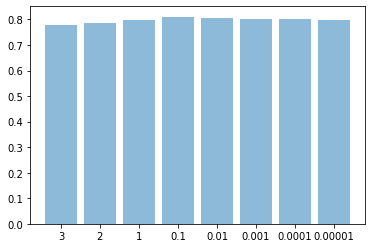

In [111]:
plt.bar(['3','2','1','0.1', '0.01', '0.001', '0.0001', '0.00001'],gs.cv_results_['mean_test_score'],align='center', alpha=0.5 )

In [112]:
#xgboost pipeline
import scipy.stats

d = {'classifier__max_depth':[5,6,7,8,9,10],
     'min_child_weight': scipy.stats.uniform(loc=0, scale=10),
     'eta': scipy.stats.uniform(loc=0, scale=2)}

ps = ParameterSampler(param_distributions=d,
                      n_iter=10, 
                      random_state=123)

In [113]:
ps.

In [89]:
rs = RandomizedSearchCV(estimator=xgb_pipe, param_distributions=d, n_iter=20, cv=4, refit=True, random_state=123, n_jobs=-1)

In [90]:
rs.fit(X_train, y_train)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/hcao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-90-38f8c562b06d>", line 1, in <module>
    rs.fit(X_train, y_train)
  File "/Users/hcao/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/Users/hcao/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py", line 736, in fit
    self._run_search(evaluate_candidates)
  File "/Users/hcao/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py", line 1531, in _run_search
    random_state=self.random_state))
  File "/Users/hcao/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py", line 715, in evaluate_candidates
    cv.split(X, y, groups)))
  File "/Users/hcao/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 1042, in __call__
  

KeyboardInterrupt: 

# 
TODO:
- confusion matrics
- McNemar
- .632+
- Randomforest